In [1]:
import os
import sys
import numpy as np
from scipy import signal
import pickle
import time
import neuron
from neuron import h
from neuron import gui
import matplotlib.pyplot as plt
from Purkinje_py3 import Purkinje_py3
from neuron import h
import multiprocessing
import numpy as np
import math
import sys
plt.rcParams.update({'font.size': 15})

--No graphics will be displayed.


In [ ]:
!nrnivmodl mod_files/

/home/mjy/anaconda3/envs/bilinear_network/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/mjy/project/bilinear_network/purkinje
Mod files: "mod_files/mod_files//Cav2_1.mod" "mod_files/mod_files//Cav3_1.mod" "mod_files/mod_files//Cav3_2.mod" "mod_files/mod_files//Cav3_3.mod" "mod_files/mod_files//cdp5.mod" "mod_files/mod_files//HCN1_Angeloetal2007.mod" "mod_files/mod_files//Kca11.mod" "mod_files/mod_files//Kca22.mod" "mod_files/mod_files//Kca31.mod" "mod_files/mod_files//Kir23.mod" "mod_files/mod_files//Kv11.mod" "mod_files/mod_files//Kv15.mod" "mod_files/mod_files//Kv33.mod" "mod_files/mod_files//Kv34.mod" "mod_files/mod_files//Kv43.mod" "mod_files/mod_files//Leak.mod" "mod_files/mod_files//Nav16.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [3]:
#fixed time step only
Fixed_step = h.CVode()
Fixed_step.active(0) #the model does not work with the variable time step!

#Instantiation of the cell template
cell = Purkinje_py3()

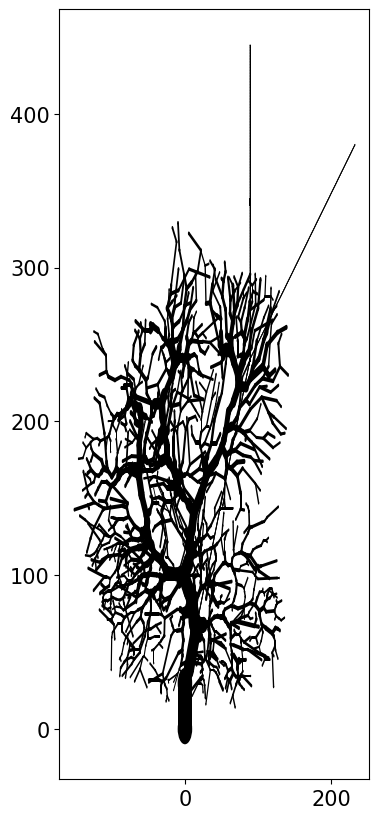

In [4]:
cell_secs = []
for sec in h.allsec(): 
    cell_secs.append(sec)
    sec.nseg = 100

locs = np.empty((100, 2))
for i in range(len(locs)):
    locs[i, 0] = int(np.random.randint(83))
    locs[i, 1] = np.random.random()
#----------------------------------------------------------------------------
# Get numbers for plotting cell morphology
# cell: [xstart xend ystart yend diamstart diamend]
# synapse: [x, y]
h.define_shape()
cell_coordinates = []
for sec in cell_secs:
    sec.push()
    for stepCount in np.arange(1, h.n3d()):
        stepCount =  float(stepCount)
        cell_coordinates.append([h.x3d(stepCount-1), h.x3d(stepCount),
                                h.y3d(stepCount-1), h.y3d(stepCount),
                                    h.diam3d(stepCount-1), h.diam3d(stepCount)])
    h.pop_section()

set_dends = set(locs[:,0])

# I don't know how to work with sets, so convert it to an array
set_dends = np.array(list(set_dends))
dend_coord = []
for i_dend in np.arange(0,len(set_dends)):
    syn_coordinates = []
    d_dend = int(set_dends[i_dend])
    if (d_dend > -1):
        cell.dend[d_dend].push()
    else :
        cell.soma.push()
    for stepCount in np.arange(1, h.n3d()):
        stepCount =  float(stepCount)
        syn_coordinates.append([h.x3d(stepCount-1), h.x3d(stepCount),
                                h.y3d(stepCount-1), h.y3d(stepCount), 
                                h.diam3d(stepCount-1), h.diam3d(stepCount)])
    h.pop_section()
    dend_coord.append(syn_coordinates)
#----------------------------------------------------------------------------

# Make plot
plt.figure(figsize=(4, 10))
# Cell
for pt in np.arange(len(cell_coordinates)):
    xstart, xend = cell_coordinates[pt][0], cell_coordinates[pt][1]
    ystart, yend = cell_coordinates[pt][2], cell_coordinates[pt][3]
    lx = xend-xstart
    ly = yend-ystart
    l = np.sqrt(np.dot([lx,ly],[lx,ly]))
    diamstart = cell_coordinates[pt][4] / 1.2 # 2
    diamend = cell_coordinates[pt][5] / 1.2  # 2

    if diamstart > 8: diamstart=diamstart/2.5 # 3.5
    if diamend > 8: diamend=diamend/2.5 # 3.5

    if l>0:
        plt.fill([xstart+2*diamstart*ly/(2*l), xend+2*diamend*ly/(2*l),
                    xend-2*diamend*ly/(2*l), xstart-2*diamstart*ly/(2*l)], 
                    [ystart-2*diamstart*lx/(2*l), yend-2*diamend*lx/(2*l),
                    yend+2*diamend*lx/(2*l), ystart+2*diamstart*lx/(2*l)],
                    'k', lw=5) 

    c1 = plt.Circle((xstart, ystart), diamstart, color='k', lw=0)
    c2 = plt.Circle((xend, yend), diamend, color='k', lw=0) 
    plt.gca().add_patch(c1)
    plt.gca().add_patch(c2)

plt.savefig('figure/only_dendrite.png', dpi=800, bbox_inches='tight')
plt.show()

In [ ]:
# ---------- Purkinje morphology: dendrites + soma circle (no connectivity) ----------
import os
import numpy as np
import matplotlib.pyplot as plt
from neuron import h

def _pt3d(sec):
    n3d = int(h.n3d(sec=sec))
    if n3d > 1:
        xs = [h.x3d(i, sec=sec) for i in range(n3d)]
        ys = [h.y3d(i, sec=sec) for i in range(n3d)]
        zs = [h.z3d(i, sec=sec) for i in range(n3d)]
        ds = [h.diam3d(i, sec=sec) for i in range(n3d)]
    else:
        xs = [0.0, sec.L]; ys = [0.0, 0.0]; zs = [0.0, 0.0]; ds = [sec.diam, sec.diam]
    return np.asarray(xs), np.asarray(ys), np.asarray(zs), np.asarray(ds)

def _to_plane(xs, ys, zs, plane):
    if plane == 'xy': return xs, ys
    if plane == 'xz': return xs, zs
    if plane == 'yz': return ys, zs
    raise ValueError("plane must be 'xy'|'xz'|'yz'")

def _is_soma(sec): return 'soma' in sec.name().lower()
def _is_axon(sec): return 'axon' in sec.name().lower()

def draw_purkinje_simple_no_connectivity(
    cell=None,
    plane='xy',
    figsize=(8, 8),
    dpi=600,
    save_prefix='figure/purkinje_simple',
    dend_color='#222222',
    dend_lw_scale=0.5,         # 线宽 = 直径 * 该系数
    soma_circle_radius_um=10.0, # 以 µm 控制 soma 小黑圆半径
    show_png=True
):
    """
    只绘制 dendrites + 独立的 soma 小黑圆；
    不保持与树突连通；
    无比例尺；
    白底；
    同时保存 PNG 与 SVG。
    """
    os.makedirs(os.path.dirname(save_prefix), exist_ok=True)
    h.define_shape()

    secs = [s for s in h.allsec()]

    # 1) 绘制树突（不含 soma / axon）
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.set_aspect('equal', adjustable='datalim')
    ax.axis('off')

    for s in secs:
        if _is_axon(s) or _is_soma(s):
            continue
        xs, ys, zs, ds = _pt3d(s)
        X, Y = _to_plane(xs, ys, zs, plane)
        for i in range(1, len(X)):
            lw = max(0.3, float(ds[i]) * dend_lw_scale)
            ax.plot([X[i-1], X[i]], [Y[i-1], Y[i]],
                    color=dend_color, lw=lw,
                    solid_capstyle='round', zorder=2)

    # 2) 独立 soma 小黑圆
    soma_pts = []
    for s in secs:
        if _is_soma(s):
            xs, ys, zs, ds = _pt3d(s)
            X, Y = _to_plane(xs, ys, zs, plane)
            soma_pts.append(np.c_[X, Y])
    if soma_pts:
        soma_center = np.vstack(soma_pts).mean(axis=0)
    else:
        soma_center = np.array([0.0, 0.0])

    soma_disc = plt.Circle((float(soma_center[0]), float(soma_center[1])),
                           soma_circle_radius_um, color='#111111', zorder=6)
    ax.add_patch(soma_disc)

    # 3) 自动范围 & 保存
    ax.relim()
    ax.autoscale()
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    pad_x = (x1 - x0) * 0.06
    pad_y = (y1 - y0) * 0.06
    ax.set_xlim(x0 - pad_x, x1 + pad_x)
    ax.set_ylim(y0 - pad_y, y1 + pad_y)

    png_path = f'{save_prefix}_{plane}.png'
    svg_path = f'{save_prefix}_{plane}.svg'

    fig.savefig(
        png_path,
        dpi=dpi,
        bbox_inches='tight',
        pad_inches=0.02,
        facecolor='white',
        edgecolor='none',
        transparent=False
    )
    fig.savefig(
        svg_path,
        dpi=dpi,
        bbox_inches='tight',
        pad_inches=0.02,
        facecolor='white',
        edgecolor='none',
        transparent=False
    )

    if show_png:
        plt.show()
    print(f"Saved:\n  {png_path}\n  {svg_path}")

# 假设你已经实例化了模型，例如：
# cell = Purkinje_py3()

draw_purkinje_simple_no_connectivity(
    cell,
    plane='xy',
    save_prefix='figure/purkinje_pub_clean',
    soma_circle_radius_um=0.0  # µm 控制 soma 圆半径
)


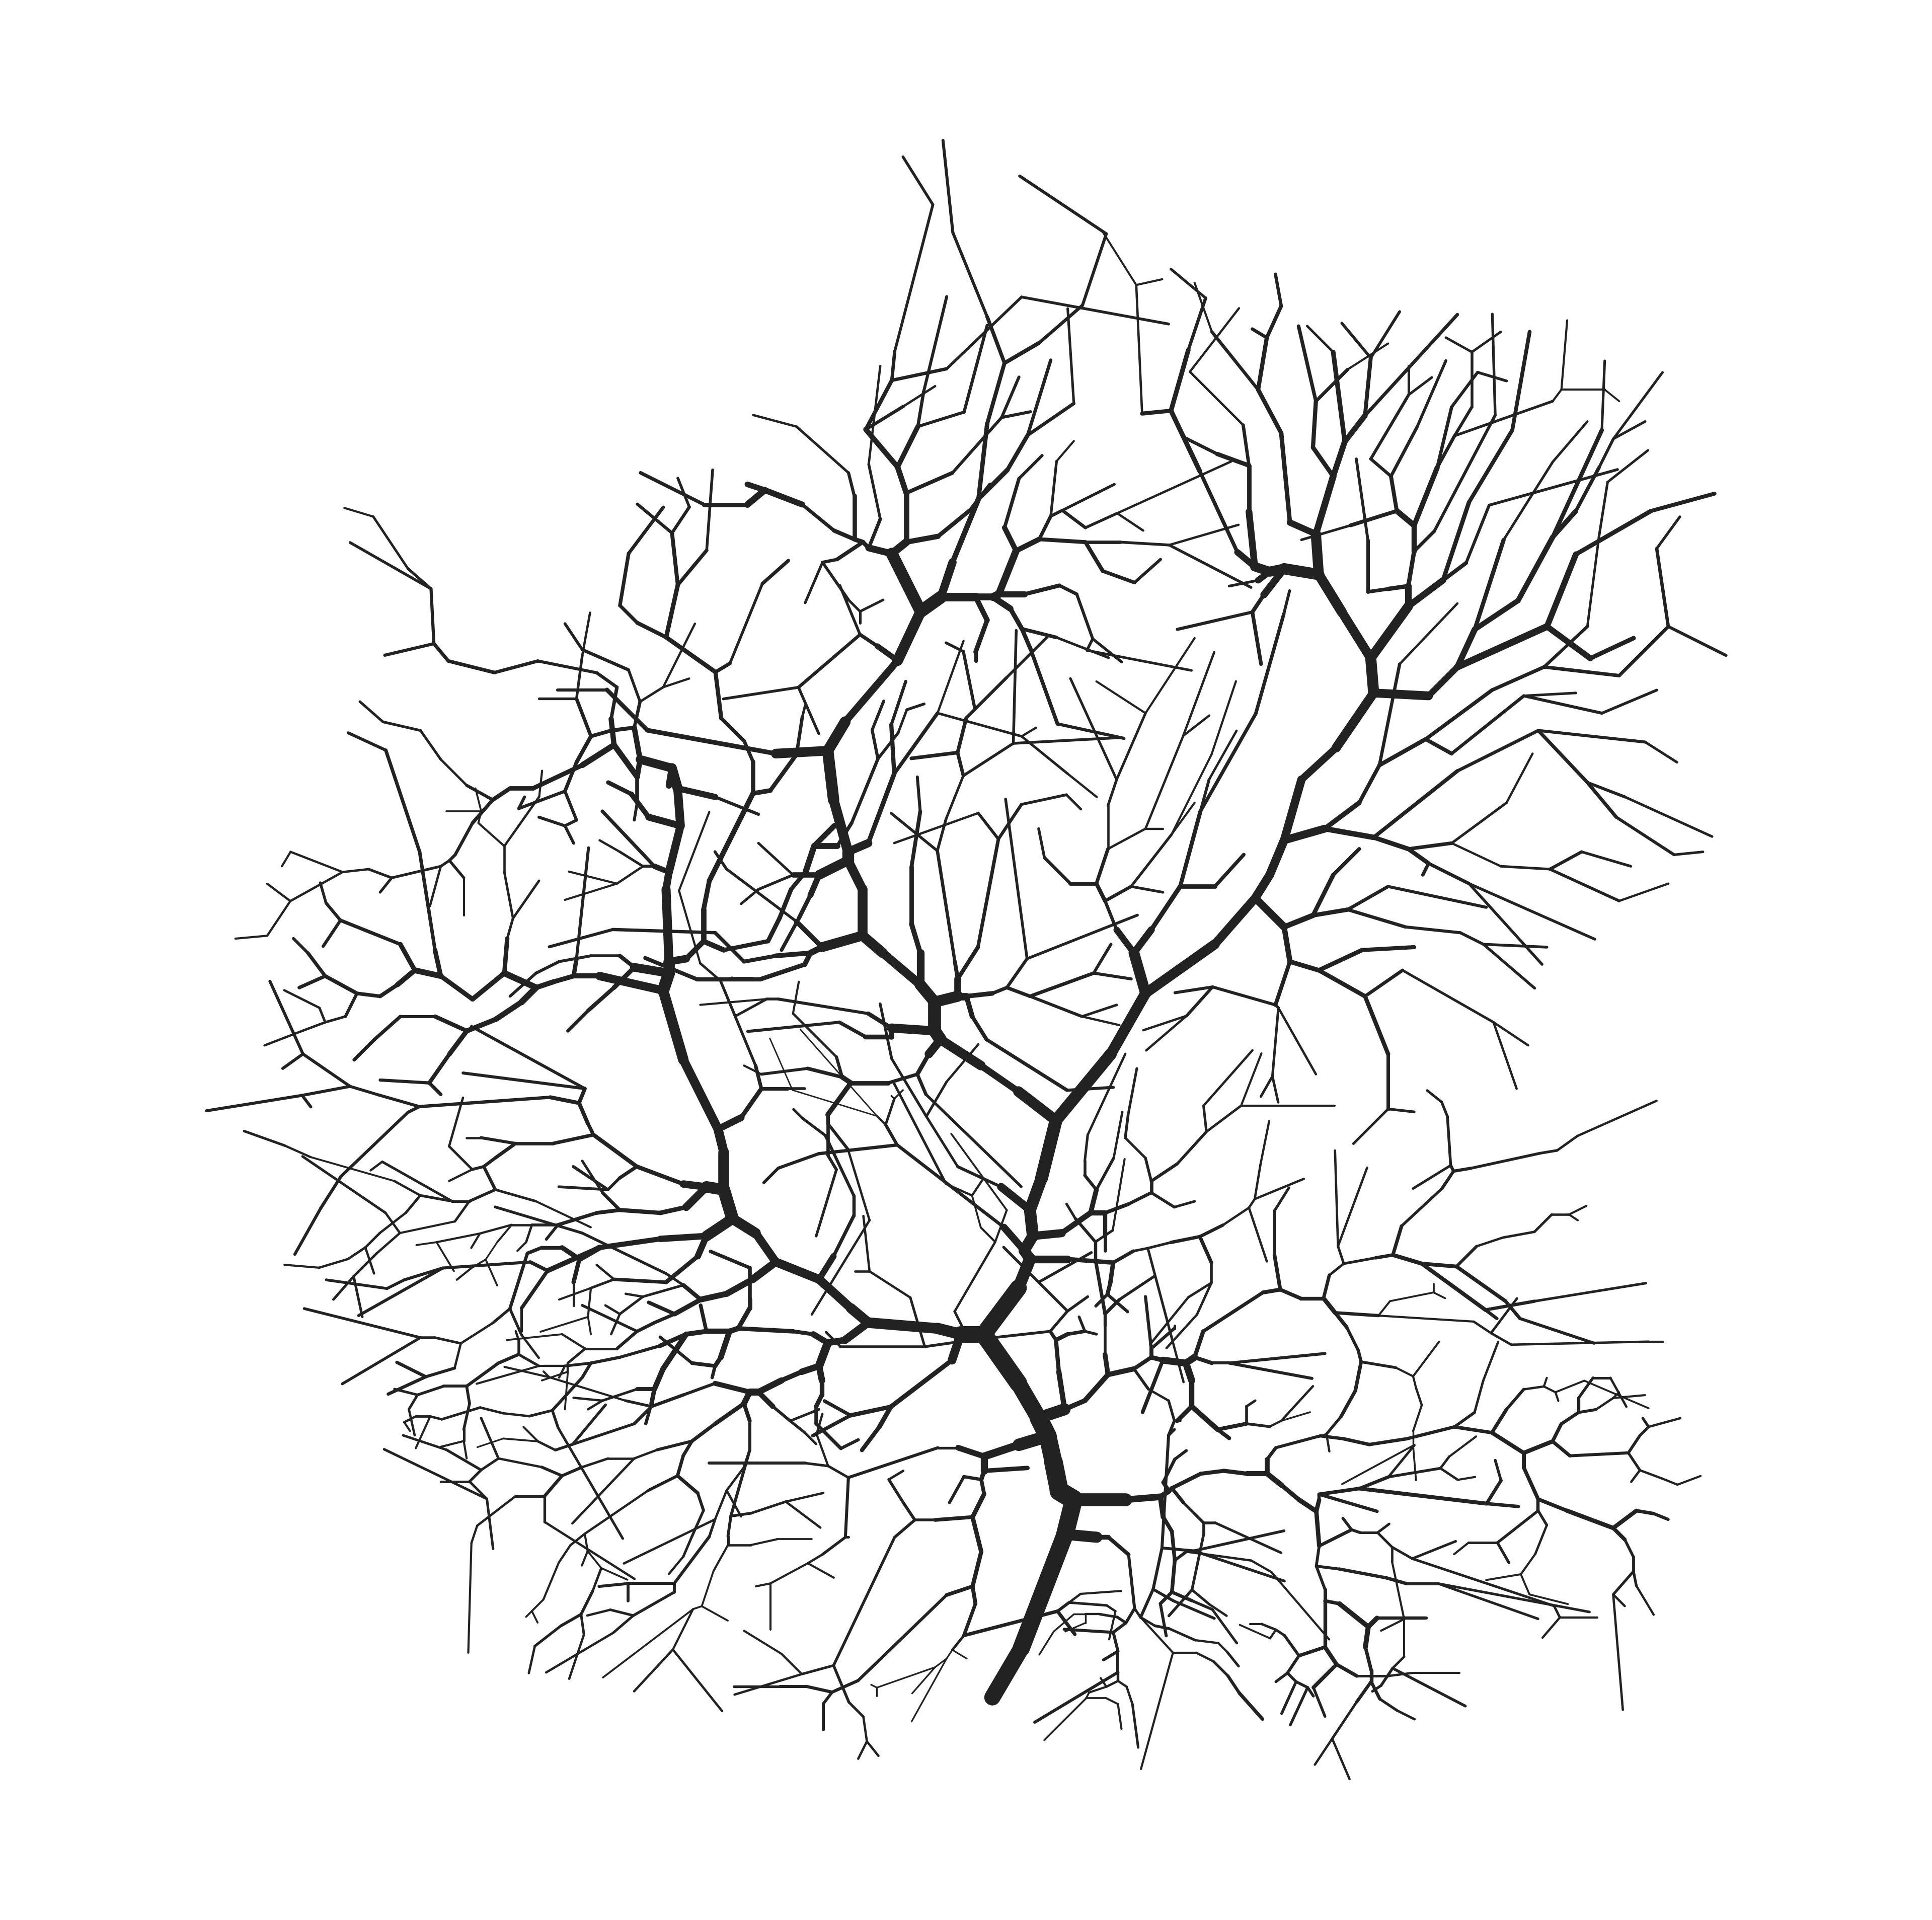

Saved:
  figure/purkinje_pub_clean_xy.png
  figure/purkinje_pub_clean_xy.svg


In [6]:
# 假设你已经实例化了模型，例如：
# cell = Purkinje_py3()

draw_purkinje_simple_no_connectivity(
    cell,
    plane='xy',
    save_prefix='figure/purkinje_pub_clean',
    soma_circle_radius_um=0.0  # µm 控制 soma 圆半径
)


In [ ]:
# ---------- Purkinje morphology + random synapses (no connectivity) ----------
import os
import numpy as np
import matplotlib.pyplot as plt
from neuron import h

def _pt3d(sec):
    n3d = int(h.n3d(sec=sec))
    if n3d > 1:
        xs = [h.x3d(i, sec=sec) for i in range(n3d)]
        ys = [h.y3d(i, sec=sec) for i in range(n3d)]
        zs = [h.z3d(i, sec=sec) for i in range(n3d)]
        ds = [h.diam3d(i, sec=sec) for i in range(n3d)]
    else:
        xs = [0.0, sec.L]; ys = [0.0, 0.0]; zs = [0.0, 0.0]; ds = [sec.diam, sec.diam]
    return np.asarray(xs), np.asarray(ys), np.asarray(zs), np.asarray(ds)

def _to_plane(xs, ys, zs, plane):
    if plane == 'xy': return xs, ys
    if plane == 'xz': return xs, zs
    if plane == 'yz': return ys, zs
    raise ValueError("plane must be 'xy'|'xz'|'yz'")

def _is_soma(sec): return 'soma' in sec.name().lower()
def _is_axon(sec): return 'axon' in sec.name().lower()

def _gather_dendrite_segments_in_plane(plane):
    """收集所有dendrite的分段（按当前平面投影），返回列表：[ (X, Y) ]，每个(X,Y)是该section的折线点。"""
    segs = []
    for s in h.allsec():
        if _is_axon(s) or _is_soma(s):
            continue
        xs, ys, zs, _ = _pt3d(s)
        X, Y = _to_plane(xs, ys, zs, plane)
        if len(X) >= 2:
            segs.append((X.copy(), Y.copy()))
    return segs

def _sample_points_on_polyline(X, Y, n, rng):
    """在一条折线上按弧长均匀随机取 n 个点（返回两个长度为 n 的数组）。"""
    dxy = np.hypot(np.diff(X), np.diff(Y))
    total = dxy.sum()
    if total <= 0:
        # 退化：给一个点
        return np.full(n, X[0]), np.full(n, Y[0])
    c = np.cumsum(dxy)
    u = rng.random(n) * total
    idx = np.searchsorted(c, u, side='right')
    idx = np.clip(idx, 0, len(dxy)-1)
    # 线性插值
    c_prev = np.where(idx == 0, 0.0, c[idx-1])
    t = (u - c_prev) / (dxy[idx] + 1e-12)
    x = X[idx]*(1.0 - t) + X[idx+1]*t
    y = Y[idx]*(1.0 - t) + Y[idx+1]*t
    return x, y

def _draw_dendrites(ax, plane, dend_color, dend_lw_scale, zorder=2):
    """绘制树突线条；返回所有dendrite折线，用于之后放点。"""
    segs = []
    for s in h.allsec():
        if _is_axon(s) or _is_soma(s):
            continue
        xs, ys, zs, ds = _pt3d(s)
        X, Y = _to_plane(xs, ys, zs, plane)
        segs.append((X.copy(), Y.copy()))
        for i in range(1, len(X)):
            lw = max(0.3, float(ds[i]) * dend_lw_scale)
            ax.plot([X[i-1], X[i]], [Y[i-1], Y[i]],
                    color=dend_color, lw=lw,
                    solid_capstyle='round', zorder=zorder)
    return segs

def _soma_center_in_plane(plane):
    """计算soma点云在当前平面的中心（简单均值）。"""
    soma_pts = []
    for s in h.allsec():
        if _is_soma(s):
            xs, ys, zs, _ = _pt3d(s)
            X, Y = _to_plane(xs, ys, zs, plane)
            soma_pts.append(np.c_[X, Y])
    if soma_pts:
        return np.vstack(soma_pts).mean(axis=0)
    return np.array([0.0, 0.0])

def draw_purkinje_with_random_synapses(
    cell=None,
    plane='xy',
    figsize=(8, 8),
    dpi=600,
    save_prefix='figure/purkinje_syn',
    dend_color='#222222',
    dend_lw_scale=0.5,          # 树突线宽比例
    soma_circle_radius_um=10.0,  # 独立soma小圆半径（µm）
    n_syn=200,                   # 突触总数
    frac_red=0.5,                # 红点比例（0~1）
    syn_size_red=8,              # 红点大小
    syn_size_black=8,            # 黑点大小
    rng_seed=0,                  # 随机种子（可复现）
    show_png=True
):
    """
    只绘制树突 + 独立soma小黑圆；不连通；无比例尺；
    并随机在树突上放置 n_syn 个突触点，其中 frac_red 比例为红点，其余为黑点。
    同时保存 PNG+SVG（白底、不透明）。
    """
    os.makedirs(os.path.dirname(save_prefix), exist_ok=True)
    h.define_shape()
    rng = np.random.default_rng(rng_seed)

    # 1) 画树突
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.set_aspect('equal', adjustable='datalim'); ax.axis('off')
    dend_segs = _draw_dendrites(ax, plane, dend_color, dend_lw_scale, zorder=2)

    # 2) 随机生成突触位置（按各段投影弧长加权）
    # 先计算每条折线的弧长
    lengths = []
    for (X, Y) in dend_segs:
        lengths.append(np.hypot(np.diff(X), np.diff(Y)).sum())
    lengths = np.asarray(lengths)
    total_len = lengths.sum()
    if total_len <= 0 or len(dend_segs) == 0:
        syn_x = np.array([]); syn_y = np.array([])
    else:
        probs = lengths / total_len
        # 为每个突触先随机选一条折线
        chosen = rng.choice(len(dend_segs), size=n_syn, p=probs)
        syn_x, syn_y = [], []
        for idx in chosen:
            X, Y = dend_segs[idx]
            x1, y1 = _sample_points_on_polyline(X, Y, n=1, rng=rng)
            syn_x.append(x1[0]); syn_y.append(y1[0])
        syn_x = np.asarray(syn_x); syn_y = np.asarray(syn_y)

    # 分成红点和黑点
    k_red = int(round(n_syn * frac_red))
    idxs = np.arange(len(syn_x))
    rng.shuffle(idxs)
    red_idx = idxs[:k_red]
    blk_idx = idxs[k_red:]

    if len(red_idx) > 0:
        ax.scatter(syn_x[red_idx], syn_y[red_idx],
                   s=syn_size_red, c='#d62828', marker='o', zorder=5)
    if len(blk_idx) > 0:
        ax.scatter(syn_x[blk_idx], syn_y[blk_idx],
                   s=syn_size_black, c='#111111', marker='o', zorder=4)

    # 3) 画独立soma小圆（不连通）
    soma_center = _soma_center_in_plane(plane)
    soma_disc = plt.Circle((float(soma_center[0]), float(soma_center[1])),
                           soma_circle_radius_um, color='#111111', zorder=6)
    ax.add_patch(soma_disc)

    # 4) 视域 & 保存
    ax.relim(); ax.autoscale()
    x0,x1 = ax.get_xlim(); y0,y1 = ax.get_ylim()
    pad_x = (x1-x0)*0.06; pad_y = (y1-y0)*0.06
    ax.set_xlim(x0-pad_x, x1+pad_x); ax.set_ylim(y0-pad_y, y1+pad_y)

    png_path = f'{save_prefix}_{plane}.png'
    svg_path = f'{save_prefix}_{plane}.svg'
    fig.savefig(
        png_path,
        dpi=dpi,
        bbox_inches='tight',
        pad_inches=0.02,
        facecolor='white',
        edgecolor='none',
        transparent=False
    )
    fig.savefig(
        svg_path,
        dpi=dpi,
        bbox_inches='tight',
        pad_inches=0.02,
        facecolor='white',
        edgecolor='none',
        transparent=False
    )
    if show_png:
        plt.show()
    print(f"Saved:\n  {png_path}\n  {svg_path}")

# 假设你已实例化模型：
# cell = Purkinje_py3()

draw_purkinje_with_random_synapses(
    cell,
    plane='xy',
    save_prefix='figure/purkinje_pub_syn',
    soma_circle_radius_um=0.0,  # 独立soma圆半径 (µm)
    n_syn=300,                   # 总突触数
    frac_red=0.7,                # 40% 红点，60% 黑点
    syn_size_red=15,
    syn_size_black=15,
    rng_seed=42                  # 可复现
)



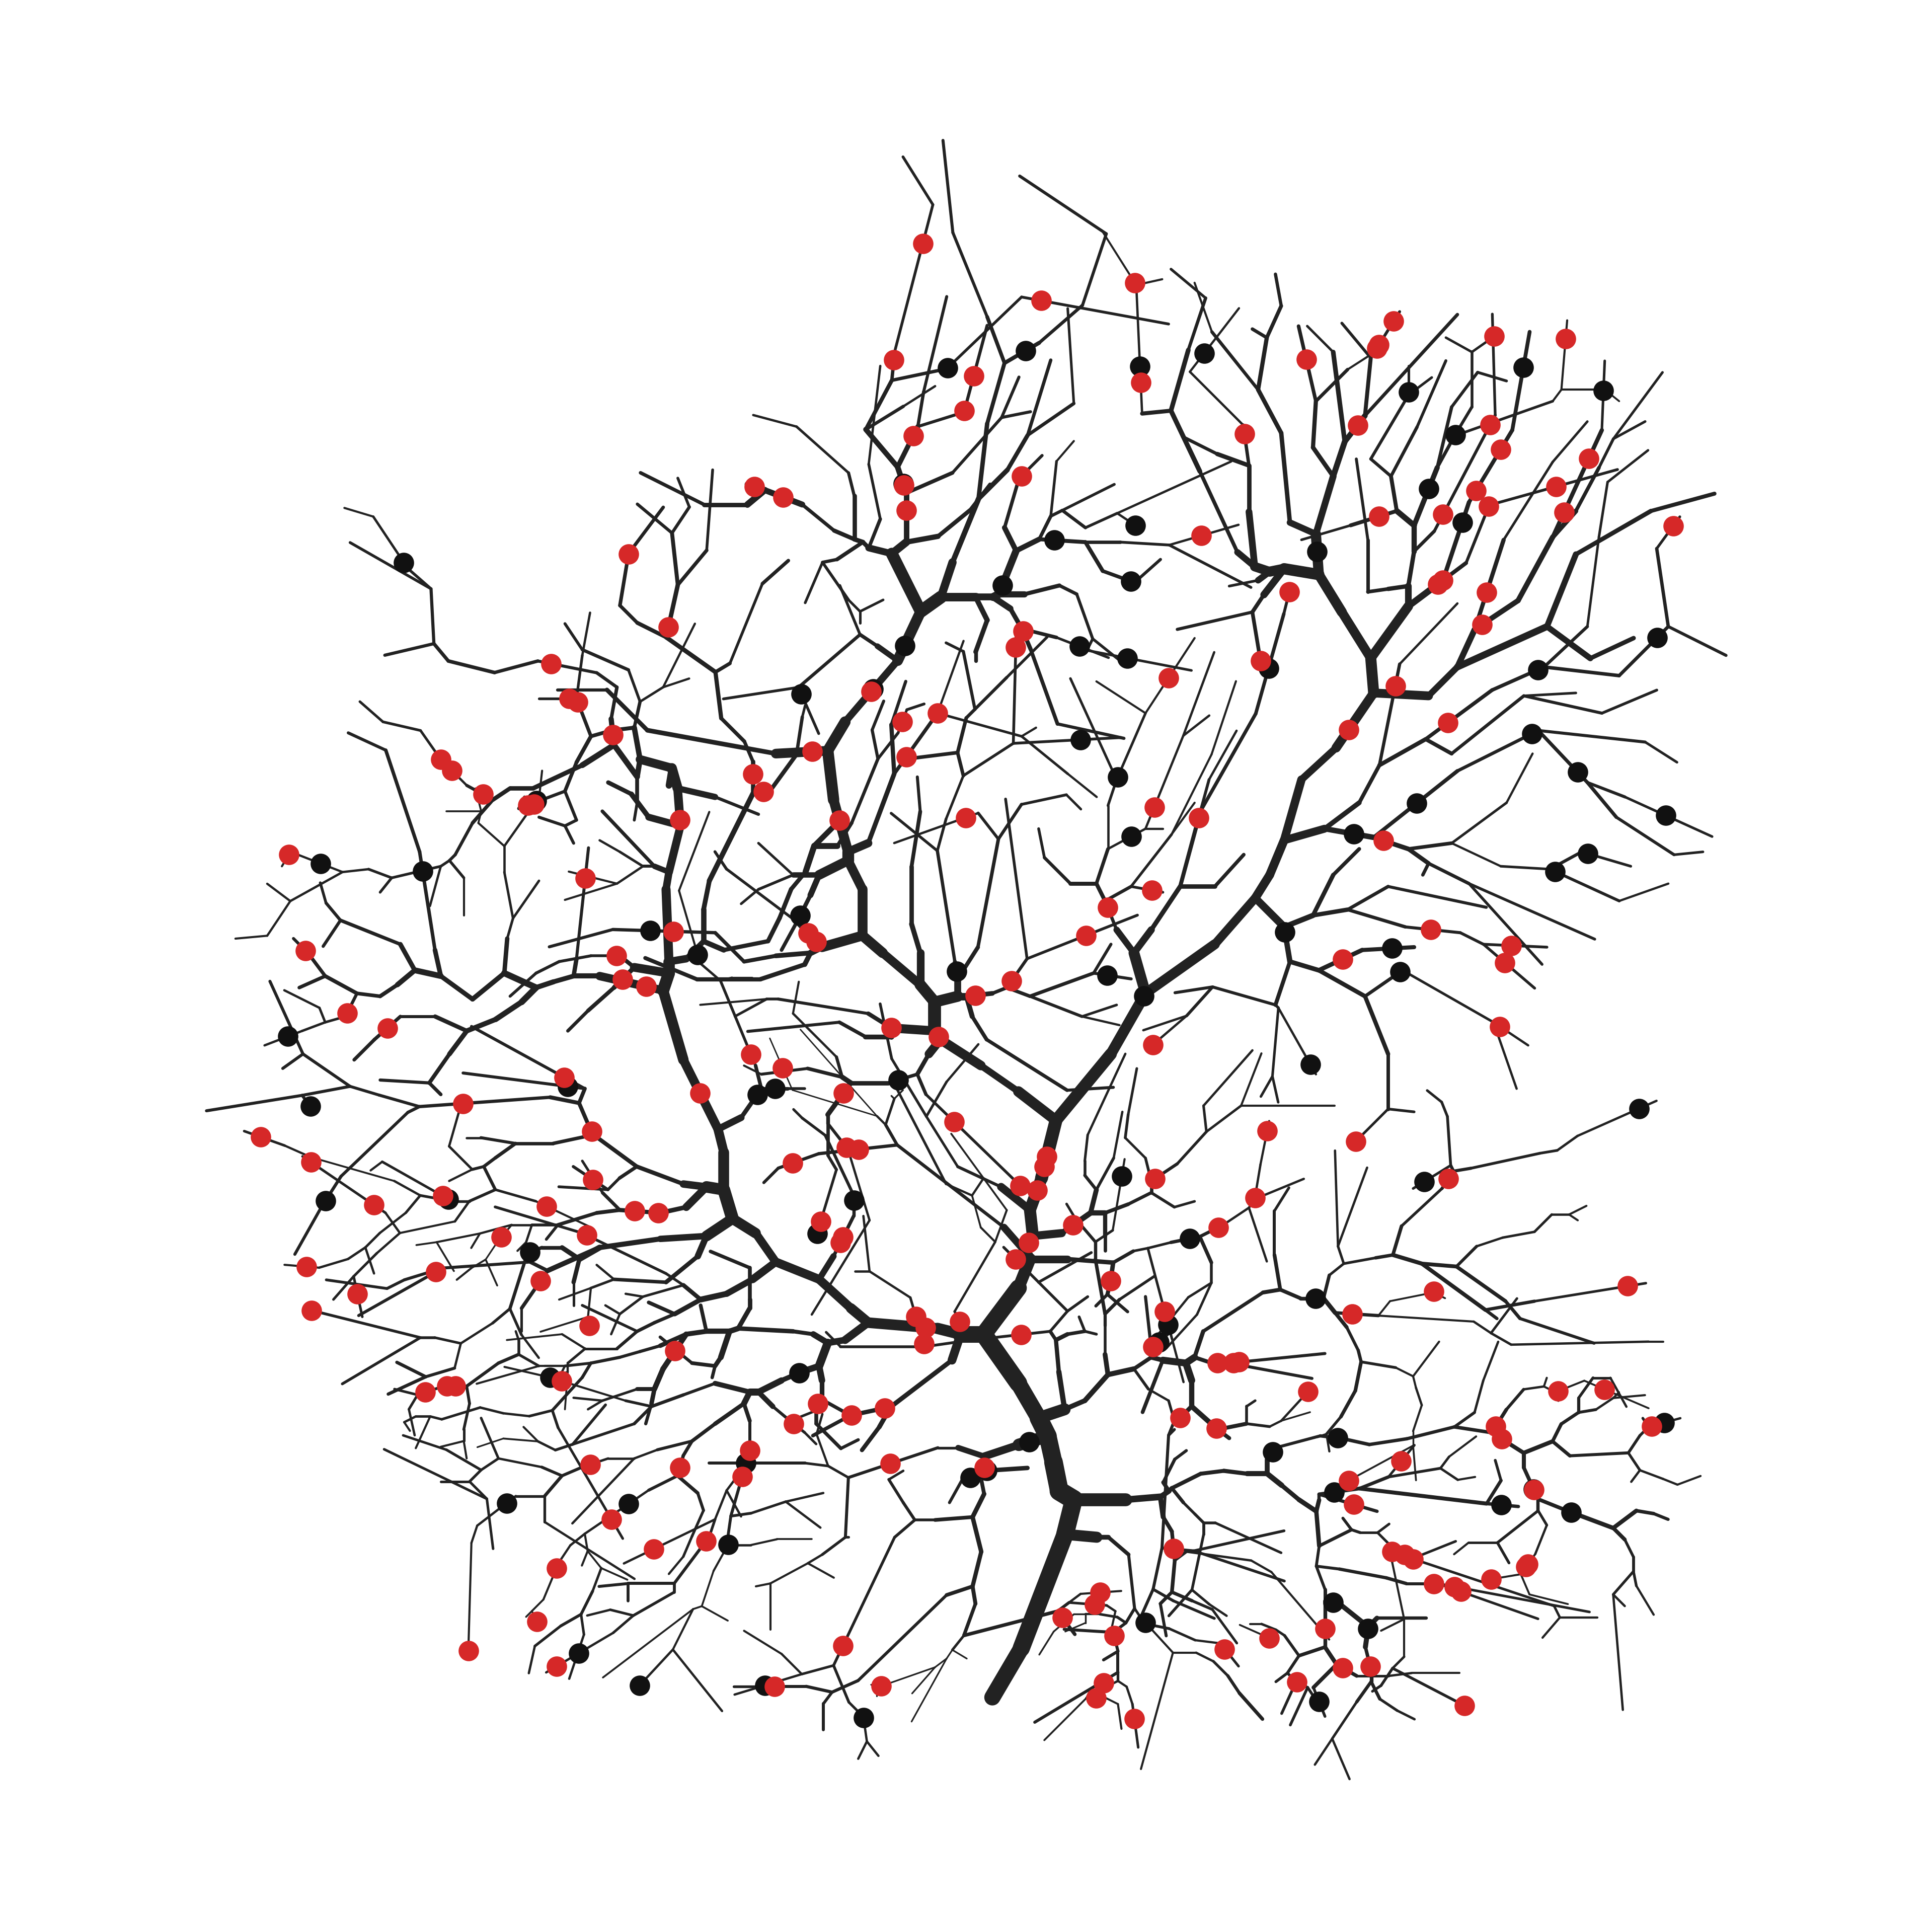

Saved:
  figure/purkinje_pub_syn_xy.png
  figure/purkinje_pub_syn_xy.svg


In [65]:
# 假设你已实例化模型：
# cell = Purkinje_py3()

draw_purkinje_with_random_synapses(
    cell,
    plane='xy',
    save_prefix='figure/purkinje_pub_syn',
    soma_circle_radius_um=0.0,  # 独立soma圆半径 (µm)
    n_syn=300,                   # 总突触数
    frac_red=0.7,                # 40% 红点，60% 黑点
    syn_size_red=15,
    syn_size_black=15,
    rng_seed=42                  # 可复现
)
